In [76]:
###basic chat bot with langgraph(graph api)

In [77]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages



In [78]:
class State(TypedDict):

    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [79]:
graph_builder

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [81]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000015EDBB86810>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000015EDBC29390>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [82]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000015EDC2840D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000015EDB970150>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [83]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [84]:
#adding node 
graph_builder.add_node("llmchatbot",chatbot)
#addding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

#complie graph

graph=graph_builder.compile()

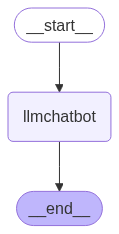

In [85]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [86]:
response=graph.invoke({"messages":"hi"})

In [87]:
response["messages"][-1].content

'How can I assist you today?'

In [88]:
for event in graph.stream({"messages":"hi how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)


I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?


In [89]:
#CHAt with tool

In [90]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)

tool.invoke("what is recent ai news" )

{'query': 'what is recent ai news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News | Latest Headlines and Developments | Reuters',
   'url': 'https://www.reuters.com/technology/artificial-intelligence/',
   'content': 'Chinese AI startup DeepSeek, which said in January it had developed an AI model to rival ChatGPT at much lower cost, has come under scrutiny in some countries for its security policies and privacy',
   'score': 0.5911811,
   'raw_content': None},
  {'title': 'Current AI News: Track the latest developments here. Updated every 4 hours!',
   'url': 'https://currentai.news/',
   'content': 'Your go-to source for the latest in artificial intelligence - research breakthroughs, product launches, funding news, and more.',
   'score': 0.57637566,
   'raw_content': None}],
 'response_time': 1.49}

In [91]:
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int: output int

    """
    return a*b
    

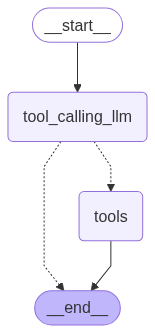

In [92]:
##state graph wit tools
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

tools=[tool,multiply]

llm_with_tool = llm.bind_tools(tools)
#node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}


#Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)
builder.add_edge("tools",END)


graph= builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))




In [93]:
result=graph.invoke({"messages":"Given me the of multiply 5 by 10"})
for i in response["messages"]:
    i.pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

How can I assist you today?


In [94]:
result["messages"][-1].content


'50'

In [95]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Given me the of multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (rx7mrh9vp)
 Call ID: rx7mrh9vp
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: multiply

50


#ReAct Agent Architecture

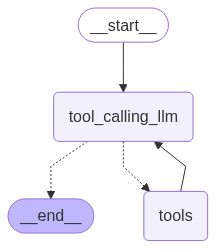

In [96]:
##state graph wit tools
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


tools=[tool,multiply]

llm_with_tool = llm.bind_tools(tools)

#node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


#Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


#add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)
builder.add_edge("tools","tool_calling_llm")


graph= builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))




In [97]:
res=graph.invoke({"messages":"Given me the recent ai news and multiply 4 with 200 "})
res["messages"]

[HumanMessage(content='Given me the recent ai news and multiply 4 with 200 ', additional_kwargs={}, response_metadata={}, id='d12f5c5f-ca8c-4db4-aa73-3fa8f4e6db9b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chtfzghh0', 'function': {'arguments': '{"query":"recent ai news","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'dzg9n3hpx', 'function': {'arguments': '{"a":4,"b":200}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 1256, 'total_tokens': 1305, 'completion_time': 0.09870069, 'prompt_time': 0.080978388, 'queue_time': 0.053783080999999996, 'total_time': 0.179679078}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--722330f6-b87f-4eda-ae0d-75909086a593-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent ai news', 'time_range': 'day', 'topic': 'n

In [98]:
for m in res["messages"]:
    m.pretty_print()

================================ Human Message =================================

Given me the recent ai news and multiply 4 with 200 
================================== Ai Message ==================================
Tool Calls:
  tavily_search (chtfzghh0)
 Call ID: chtfzghh0
  Args:
    query: recent ai news
    time_range: day
    topic: news
  multiply (dzg9n3hpx)
 Call ID: dzg9n3hpx
  Args:
    a: 4
    b: 200
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.fintechfutures.com/ai-in-fintech/june-2025-top-five-ai-stories-of-the-month", "title": "June 2025: Top five AI stories of the month - FinTech Futures", "score": 0.7382357, "published_date": "Mon, 30 Jun 2025 12:18:53 GMT", "content": "AI - FinTech News Here, FinTech Futures recaps five of the top AI stories from June, featuring NatWest, Nvidia, Danske Bank an

#Adding Memory In Agentic GRaph

In [99]:
res=graph.invoke({"messages":"hello my name is krish"})
for z in res["messages"]:
    z.pretty_print()

================================ Human Message =================================

hello my name is krish
================================== Ai Message ==================================

Hello Krish. How can I assist you today?


In [100]:
res=graph.invoke({"messages":"what is my name"})
for z in res["messages"]:
    z.pretty_print()

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

I don't have any information about your name. If you'd like to share it with me, I can try to recall it for our conversation.


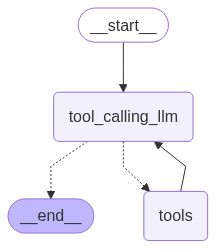

In [101]:
##state graph wit tools
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


tools=[tool,multiply]

llm_with_tool = llm.bind_tools(tools)

#node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


#Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


#add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)
builder.add_edge("tools","tool_calling_llm")


graph= builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))



In [102]:
config = {"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"hi my name is dheeraj"},config=config)

response


{'messages': [HumanMessage(content='hi my name is dheeraj', additional_kwargs={}, response_metadata={}, id='354d478c-8fb5-4e20-8246-935ecf526ec2'),
  AIMessage(content='Nice to meet you, Dheeraj. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1249, 'total_tokens': 1267, 'completion_time': 0.024, 'prompt_time': 0.081222256, 'queue_time': 0.05266982499999999, 'total_time': 0.105222256}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--5001521f-4b7e-45be-a86d-5423bdf00741-0', usage_metadata={'input_tokens': 1249, 'output_tokens': 18, 'total_tokens': 1267})]}

In [103]:
response["messages"][-1].content

'Nice to meet you, Dheeraj. How can I assist you today?'

In [104]:
response=graph.invoke({"messages":"hi do you knw my name"},config=config)

response["messages"][-1].content

'Yes, I do know your name, Dheeraj. What would you like to discuss or ask about?'

#Streaming

In [114]:
from langgraph.checkpoint.memory import MemorySaver
memory= MemorySaver()

In [115]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}


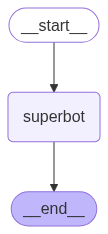

In [116]:
graph=StateGraph(State)

graph.add_node("superbot",superbot)

graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)

graph_builder=graph.compile(checkpointer=memory)

from IPython.display import display

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [117]:
config = {"configurable":{"thread_id":"1"}}

response=graph_builder.invoke({"messages":"hi my name is dheeraj and i like badminton"},config=config)

response

{'messages': [HumanMessage(content='hi my name is dheeraj and i like badminton', additional_kwargs={}, response_metadata={}, id='8e4e3d4f-86a5-450c-ae4e-bd21ddb57bca'),
  AIMessage(content="Hello Dheeraj.  It's nice to meet you.  Badminton is a fantastic sport, it's great that you enjoy playing it. \n\nAre you a beginner, intermediate, or advanced badminton player? Have you participated in any local or national tournaments?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 48, 'total_tokens': 106, 'completion_time': 0.090081959, 'prompt_time': 0.002396934, 'queue_time': 0.049813986000000005, 'total_time': 0.092478893}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--4a0d0b6c-ce1d-4dad-bc60-315ca902022e-0', usage_metadata={'input_tokens': 48, 'output_tokens': 58, 'total_tokens': 106})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [118]:
config ={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"hi my name is dheeraj and i like badminton"},config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Hello Dheeraj, nice to meet you.  Badminton is a fantastic sport, it's a great way to stay active, improve your hand-eye coordination, and have fun while playing with friends. Are you an avid player or do you play for leisure?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 48, 'total_tokens': 104, 'completion_time': 0.13773823, 'prompt_time': 0.002804269, 'queue_time': 0.049366302, 'total_time': 0.140542499}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run--74909b78-335b-44b5-87cb-4f04e43f6a40-0', usage_metadata={'input_tokens': 48, 'output_tokens': 56, 'total_tokens': 104})]}}


In [119]:
config ={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"hi my name is dheeraj and i like badminton"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='hi my name is dheeraj and i like badminton', additional_kwargs={}, response_metadata={}, id='d91eb189-fc34-44a2-8f50-54bc13dd6ade'), AIMessage(content="Hello Dheeraj, nice to meet you.  Badminton is a fantastic sport, it's a great way to stay active, improve your hand-eye coordination, and have fun while playing with friends. Are you an avid player or do you play for leisure?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 48, 'total_tokens': 104, 'completion_time': 0.13773823, 'prompt_time': 0.002804269, 'queue_time': 0.049366302, 'total_time': 0.140542499}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run--74909b78-335b-44b5-87cb-4f04e43f6a40-0', usage_metadata={'input_tokens': 48, 'output_tokens': 56, 'total_tokens': 104}), HumanMessage(content='hi my name is dheeraj and i like badminton', additional_kwargs={}, respo

In [122]:
config ={"configurable":{"thread_id":"5"}}

for chunk in graph_builder.stream({"messages":"hi my name is dheeraj and i like badminton"},config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Hi Dheeraj, nice to meet you. Badminton is a great sport, isn't it? It's a fantastic way to stay active, improve your hand-eye coordination, and have fun with friends and family. Which level of badminton do you play, beginner or more advanced?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 48, 'total_tokens': 110, 'completion_time': 0.09561108, 'prompt_time': 0.002386855, 'queue_time': 0.048258105, 'total_time': 0.097997935}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run--e2ca498d-dab6-446c-8045-42e410d03983-0', usage_metadata={'input_tokens': 48, 'output_tokens': 62, 'total_tokens': 110})]}}


In [123]:
for chunk in graph_builder.stream({"messages":"i also like football too"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='hi my name is dheeraj and i like badminton', additional_kwargs={}, response_metadata={}, id='f7985c0a-5717-4570-8a73-5ea11197a858'), AIMessage(content="Hi Dheeraj, nice to meet you. Badminton is a great sport, isn't it? It's a fantastic way to stay active, improve your hand-eye coordination, and have fun with friends and family. Which level of badminton do you play, beginner or more advanced?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 48, 'total_tokens': 110, 'completion_time': 0.09561108, 'prompt_time': 0.002386855, 'queue_time': 0.048258105, 'total_time': 0.097997935}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run--e2ca498d-dab6-446c-8045-42e410d03983-0', usage_metadata={'input_tokens': 48, 'output_tokens': 62, 'total_tokens': 110}), HumanMessage(content='i also like football too', additional_kwargs={}, respon

{'messages': [HumanMessage(content='hi my name is dheeraj and i like badminton', additional_kwargs={}, response_metadata={}, id='f7985c0a-5717-4570-8a73-5ea11197a858'), AIMessage(content="Hi Dheeraj, nice to meet you. Badminton is a great sport, isn't it? It's a fantastic way to stay active, improve your hand-eye coordination, and have fun with friends and family. Which level of badminton do you play, beginner or more advanced?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 48, 'total_tokens': 110, 'completion_time': 0.09561108, 'prompt_time': 0.002386855, 'queue_time': 0.048258105, 'total_time': 0.097997935}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run--e2ca498d-dab6-446c-8045-42e410d03983-0', usage_metadata={'input_tokens': 48, 'output_tokens': 62, 'total_tokens': 110}), HumanMessage(content='i also like football too', additional_kwargs={}, respon

In [126]:
config ={"configurable":{"thread_id":"6"}}

async for chunk in graph_builder.astream_events({"messages":"hi my name is dheeraj and i like badminton"},config,version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'hi my name is dheeraj and i like badminton'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2a10730d-6c3e-4e51-bdfc-d12150f3a5e1', 'metadata': {'thread_id': '6'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='hi my name is dheeraj and i like badminton', additional_kwargs={}, response_metadata={}, id='455c9f66-1a13-4e18-b87f-3c9130d60224')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': '162ddcf1-12df-4a27-b69a-156df673100d', 'metadata': {'thread_id': '6', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:9626f236-0292-4936-54e9-8b3a6a6651b4'}, 'parent_ids': ['2a10730d-6c3e-4e51-bdfc-d12150f3a5e1']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='hi my name is dheeraj and i like badminton', ad